# Data aggregations

Purpose of this notebook is to create data aggregations from Pecan Street dataset. 

In [1]:
import os
from datetime import datetime

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Folder in which we will save the created aggregations.

In [2]:
try:
    os.stat('.exports/aggregations/')
except:
    os.mkdir('.exports/aggregations/')

In [3]:
df = pd.read_csv('.data/user_data_raw/dataport-export.csv')

In [4]:
df.head()

,localminute,dataid,use,gen,grid
0,2014-01-01 00:00:00-06,26,1.817583,0.000000,1.817583
1,2014-01-01 00:00:00-06,5545,0.201817,-0.008000,0.201817
2,2014-01-01 00:00:00-06,93,1.748767,-0.005000,1.748767
3,2014-01-01 00:00:00-06,5357,1.242767,-0.020000,1.242767
4,2014-01-01 00:00:00-06,114,0.252083,-0.006983,0.252083


Parse the timestamp provided in `localminute` column, so we can select items by date more conveniently.

In [5]:
datetimes = [datetime.strptime(x, '%Y-%m-%d %H:00:00-%M') for x in df['localminute']]

And add parsed values as columns to dataframe.

In [6]:
df['year'] = [x.year for x in datetimes]
df['month'] = [x.month for x in datetimes]
df['day'] = [x.day for x in datetimes]
df['hour'] = [x.hour for x in datetimes]
df['weekday'] = [x.weekday() for x in datetimes]
df['weekend'] = [0 if not x.weekday() in [5,6] else 1 for x in datetimes]

Function to help us select start and end index of particular date.

In [7]:
def get_start_and_end_index(df, st_dt, end_dt):

    start_index = df[(df['year'] == st_dt.year)
                     & (df['month'] == st_dt.month)
                     & (df['day'] == st_dt.day)].index[0]
    
    end_index = df[(df['year'] == end_dt.year)
                     & (df['month'] == end_dt.month)
                     & (df['day'] == end_dt.day)].index[-1]
    
    return (start_index, end_index)

Now select start and end indices of year seasons.

In [8]:
spring_start, spring_end = get_start_and_end_index(df, datetime(2014,3,20), datetime(2014,6,19))
summer_start, summer_end = get_start_and_end_index(df, datetime(2014,6,20), datetime(2014,9,21))
fall_start, fall_end = get_start_and_end_index(df, datetime(2014,9,22), datetime(2014,12,20))
winter_start, winter_end = get_start_and_end_index(df, datetime(2014,12,21), datetime(2015,3,19))

In [9]:
df_spring = df.iloc[spring_start:spring_end,:]
df_summer = df.iloc[summer_start:summer_end,:]
df_fall   = df.iloc[fall_start:fall_end,:]
df_winter = df.iloc[winter_start:winter_end,:]

Plot the spring data, because we can.

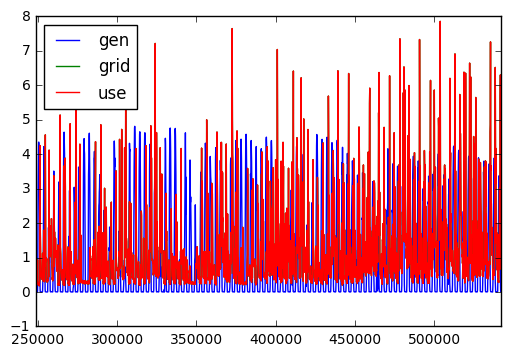

In [10]:
df_spring[df_spring['dataid'] == 26][['gen', 'grid', 'use']].plot()

In [11]:
df_spring.head()

,localminute,dataid,use,gen,grid,year,month,day,hour,weekday,weekend
248795,2014-03-20 00:00:00-05,2449,0.767550,-0.004317,0.767550,2014,3,20,0,3,0
248796,2014-03-20 00:00:00-05,6941,0.429667,-0.011000,0.429667,2014,3,20,0,3,0
248797,2014-03-20 00:00:00-05,1192,0.485283,-0.003117,0.485283,2014,3,20,0,3,0
248798,2014-03-20 00:00:00-05,7731,0.204000,-0.015000,0.204000,2014,3,20,0,3,0
248799,2014-03-20 00:00:00-05,4336,4.359567,-0.010067,4.359567,2014,3,20,0,3,0


(0, 4.5)

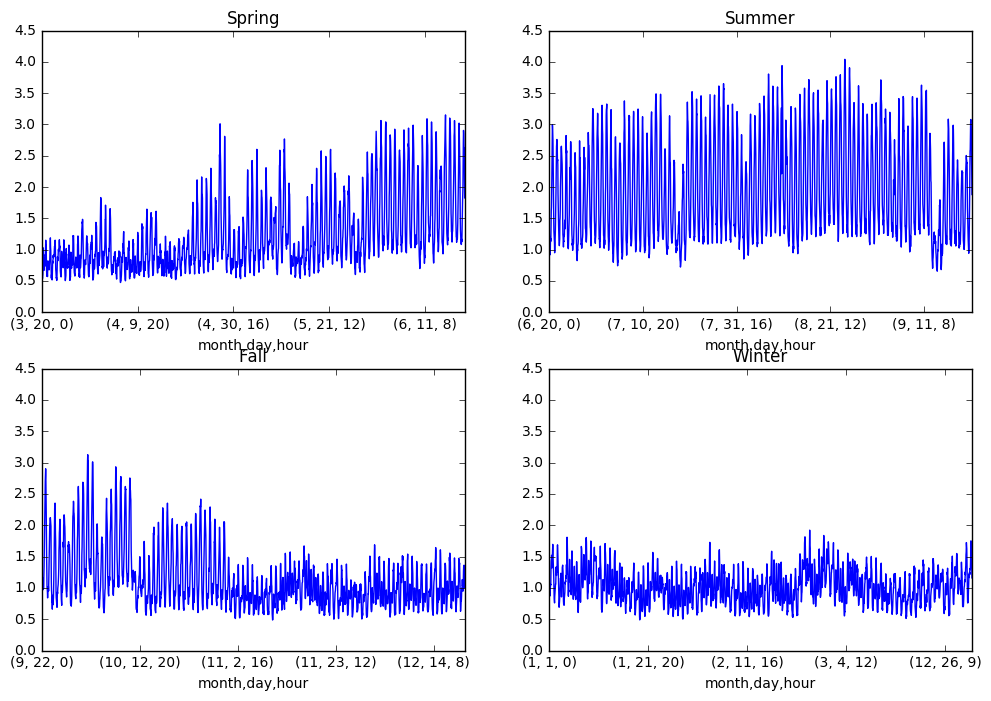

In [12]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(12,8))

grouping = ['month', 'day', 'hour']
attr = 'use'

df_spring.groupby(grouping)[attr].mean().plot(ax=ax1)
ax1.set_title('Spring')
ax1.set_ylim(0,4.5)
df_summer.groupby(grouping)[attr].mean().plot(ax=ax2)
ax2.set_title('Summer')
ax2.set_ylim(0,4.5)
df_fall.groupby(grouping)[attr].mean().plot(ax=ax3)
ax3.set_title('Fall')
ax3.set_ylim(0,4.5)
df_winter.groupby(grouping)[attr].mean().plot(ax=ax4)
ax4.set_title('Winter')
ax4.set_ylim(0,4.5)

# Global average

Averaged consumption of all users.

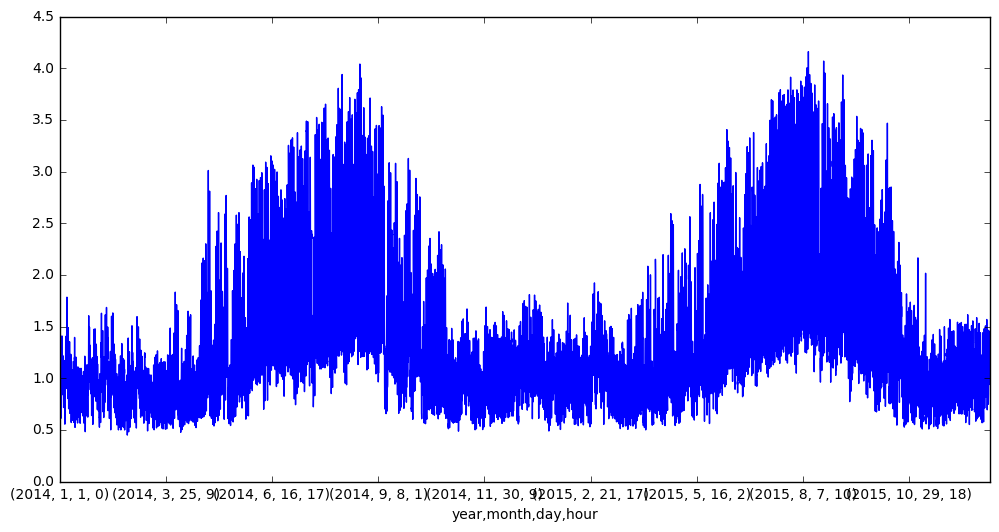

In [13]:
df.groupby(['year', 'month', 'day', 'hour'])['use'].mean().plot(figsize=(12,6))

And save averaged data to CSV file.

In [14]:
df.groupby(['year', 'month', 'day', 'hour'])['use'].mean().to_csv('.exports/aggregations/average_all_users.csv')

# Average by city

Averaged consumption of all users from particular city, in our case - Dallas and Austin. In order to determine, which user is from which city, we need to load metadata.

In [15]:
meta = pd.read_csv('.data/dataport-metadata.csv')

## Dallas

Load, plot, export, conquer.

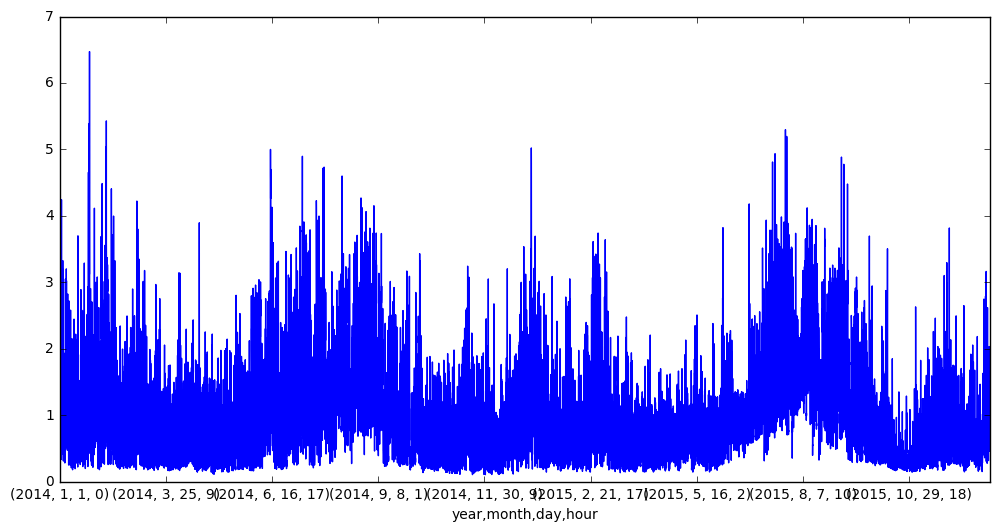

In [16]:
dallas_id = meta[meta['city'] == 'Dallas'].dataid.as_matrix()

dallas_df = df[df['dataid'].isin(dallas_id)]
mean = dallas_df.groupby(['year', 'month', 'day', 'hour'])['use'].mean()
mean.plot(figsize=(12,6))

mean.to_csv('.exports/aggregations/average_dallas_users.csv')

## Austin

And again.

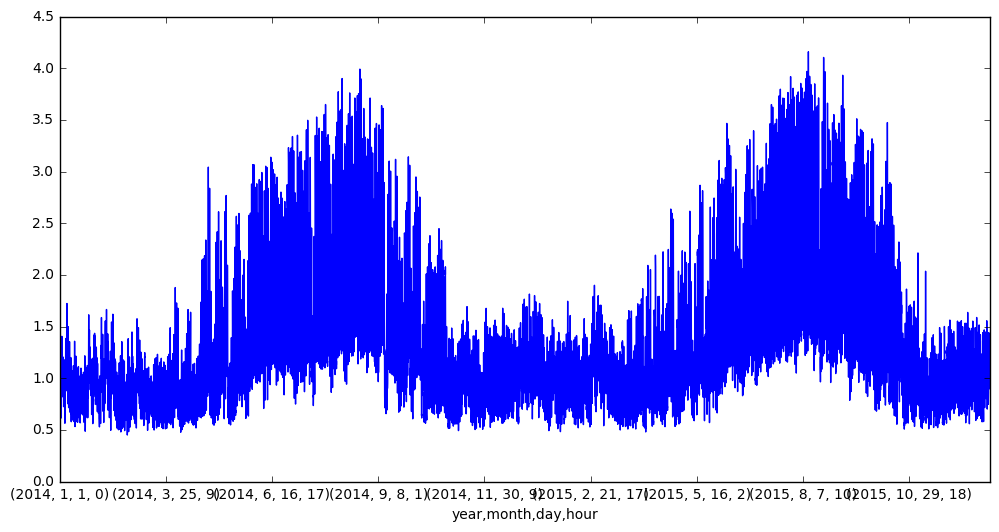

In [17]:
austin_id = meta[meta['city'] == 'Austin'].dataid.as_matrix()

austin_df = df[df['dataid'].isin(austin_id)]
mean = austin_df.groupby(['year', 'month', 'day', 'hour'])['use'].mean()
mean.plot(figsize=(12,6))

mean.to_csv('.exports/aggregations/average_austin_users.csv')


# 4 seasons average by day for user

Now we want to create average consumption of particular weekday of single user, for each season individualy. This function takes a dataframe, from which it create average for each user and save it as CSV.

In [18]:
def export_seasonal_averages_for_users(source_df, season):
    grouped = source_df.groupby(['dataid', 'weekday', 'hour'])['use'].mean()
    flatten = pd.DataFrame(grouped).reset_index()
    dataids = flatten.dataid.unique()
    
    try:
        os.stat('.exports/aggregations/' + season)
    except:
        os.mkdir('.exports/aggregations/' + season)
    
    for dataid in dataids:
        flatten[flatten['dataid'] == dataid].to_csv('.exports/aggregations/' + season + '/average_weekday_' + str(dataid) + '.csv')

Now lets fill the dataframes of seasons to previous function.

In [19]:
export_seasonal_averages_for_users(df_spring, 'spring')

In [20]:
export_seasonal_averages_for_users(df_summer, 'summer')

In [21]:
export_seasonal_averages_for_users(df_fall, 'fall')

In [22]:
export_seasonal_averages_for_users(df_winter, 'winter')

# Winter and summer average by day for user

Four seasons are nice, but the pricing was for two periods - winter and summer, so we also need to create similar aggregation (daily average consumption for weekdays) for these two. Since the data start at 1.1.2014 and end at 31.12.2015, we need to split it in three parts, to get the (two) winters.

In [23]:
lw1_start, lw1_end = get_start_and_end_index(df, datetime(2014,1,1), datetime(2014,3,31))
lw2_start, lw2_end = get_start_and_end_index(df, datetime(2014,11,1), datetime(2015,3,31))
lw3_start, lw3_end = get_start_and_end_index(df, datetime(2015,11,1), datetime(2015,12,31))

In [24]:
lw_df = pd.concat([df.iloc[lw1_start:lw1_end,:], df.iloc[lw2_start:lw2_end,:], df.iloc[lw3_start:lw3_end,:]])

In [25]:
ls1_start, ls1_end = get_start_and_end_index(df, datetime(2014,4,1), datetime(2014,10,31))
ls2_start, ls2_end = get_start_and_end_index(df, datetime(2015,4,1), datetime(2015,10,31))

In [26]:
ls_df = pd.concat([df.iloc[ls1_start:ls1_end,:], df.iloc[ls2_start:ls2_end,:]])

In [27]:
export_seasonal_averages_for_users(lw_df, 'long_winter')

In [28]:
export_seasonal_averages_for_users(ls_df, 'long_summer')

In [29]:
lw_df.head()

,localminute,dataid,use,gen,grid,year,month,day,hour,weekday,weekend
0,2014-01-01 00:00:00-06,26,1.817583,0.000000,1.817583,2014,1,1,0,2,0
1,2014-01-01 00:00:00-06,5545,0.201817,-0.008000,0.201817,2014,1,1,0,2,0
2,2014-01-01 00:00:00-06,93,1.748767,-0.005000,1.748767,2014,1,1,0,2,0
3,2014-01-01 00:00:00-06,5357,1.242767,-0.020000,1.242767,2014,1,1,0,2,0
4,2014-01-01 00:00:00-06,114,0.252083,-0.006983,0.252083,2014,1,1,0,2,0


Similar function as previously, this one groups data according to whether it is weekend or not. Furthermore returns the data, so we can plot it later.

In [30]:
def export_seasonal_averages_for_users_by_type_of_day(source_df, season):
    grouped = source_df.groupby(['dataid', 'weekend', 'hour'])['use'].mean()
    flatten = pd.DataFrame(grouped).reset_index()
    dataids = flatten.dataid.unique()
    
    for dataid in dataids:
        flatten[flatten['dataid'] == dataid].to_csv('.exports/aggregations/' + season + '/average_weekday_' + str(dataid) + '.csv')
    
    return flatten

In [31]:
lw_agg_df = export_seasonal_averages_for_users_by_type_of_day(lw_df, 'long_winter_day_type')

In [32]:
ls_agg_df = export_seasonal_averages_for_users_by_type_of_day(ls_df, 'long_summer_day_type')

## Average consumption on winter work day

The later plotting mentioned earlier. This drawnings goes to the paper.

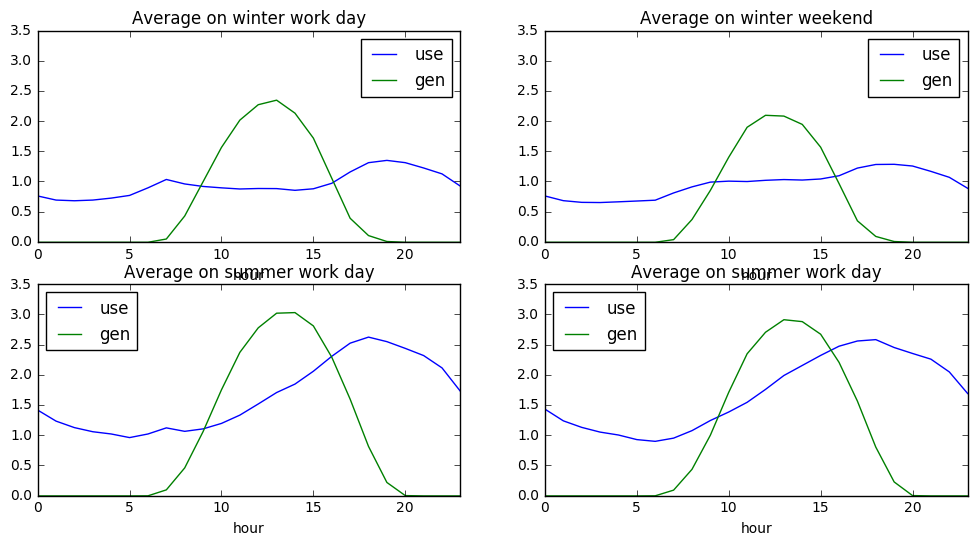

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,6))

ax1.set_title('Average on winter work day')
winter_work_day = lw_df[lw_df['weekend'] == 0].groupby(['hour'])[['use','gen']].mean()
winter_work_day.plot(ax=ax1)

ax2.set_title('Average on winter weekend')
winter_weekend = lw_df[lw_df['weekend'] == 1].groupby(['hour'])[['use','gen']].mean()
winter_weekend.plot(ax=ax2)

ax3.set_title('Average on summer work day')
summer_work_day = ls_df[ls_df['weekend'] == 0].groupby(['hour'])[['use', 'gen']].mean()
summer_work_day.plot(ax=ax3)

ax4.set_title('Average on summer work day')
summer_weekend = ls_df[ls_df['weekend'] == 1].groupby(['hour'])[['use', 'gen']].mean()
summer_weekend.plot(ax=ax4)

def set_axis_limits(axis):
    for a in axis:
        a.set_ylim(0, 3.5)

set_axis_limits([ax1, ax2, ax3, ax4])

Export the averages to CSV.

In [34]:
summer_weekend.to_csv('.exports/aggregations/average_summer_weekend.csv')
summer_work_day.to_csv('.exports/aggregations/average_summer_workday.csv')
winter_weekend.to_csv('.exports/aggregations/average_winter_weekday.csv')
winter_work_day.to_csv('.exports/aggregations/average_winter_workday.csv')

## Average consumption on winter and summer day

Another plotting, like it isn't enough.

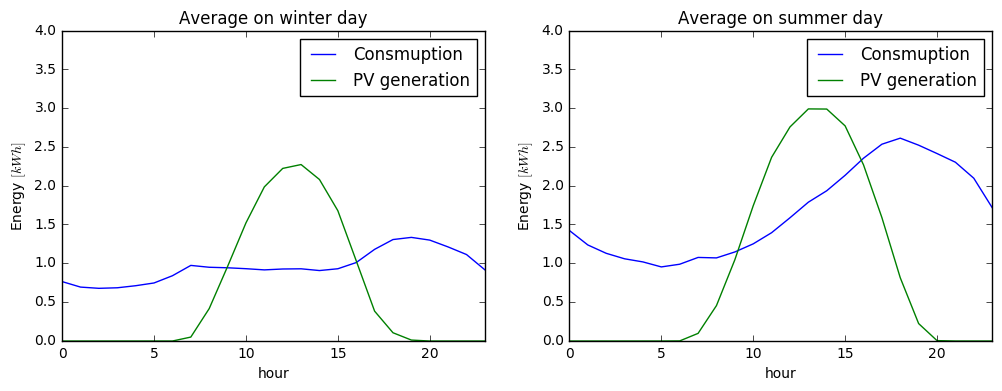

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.set_title('Average on winter day')
ax1.set_ylim(0,4)
ax1.set_ylabel('Energy $[kWh]$')
winter_day = lw_df.groupby(['hour'])[['use','gen']].mean()
winter_day.plot(ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, ['Consmuption', 'PV generation'])

ax2.set_title('Average on summer day')
ax2.set_ylim(0,4)
ax2.set_ylabel('Energy $[kWh]$')
summer_day = ls_df.groupby(['hour'])[['use','gen']].mean()
summer_day.plot(ax=ax2)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, ['Consmuption', 'PV generation'])

plt.savefig('.exports/average days.jpg', dpi=1000)

In [36]:
summer_day.to_csv('.exports/aggregations/average_summer_day.csv')
winter_day.to_csv('.exports/aggregations/average_winter_day.csv')